# Processing Data and Making 2D Images

This notebook demonstrates how to open a Nanosurf image file (*.nid) and perform basic post-processing operations.

You can download NSFopen package by "pip install nanosurf" or "pip install NSFopen".

In [ ]:
pip install NSFopen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import required modules
from NSFopen.read import read
from scipy.ndimage import rotate
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import the data
#/content/drive/Mydrive/
filename = "/content/drive/MyDrive/PL3/AFM/Chip.nid"

afm = read(filename)
data = afm.data

In [ ]:
print(data)

Image  Forward   Deflection    [[0.3662109375, 0.3668212890625, 0.36804199218...
                 Z-Axis        [[5.567016601562503e-07, 5.680236816406247e-07...
       Backward  Deflection    [[0.3619384765625, 0.36285400390625, 0.3695678...
                 Z-Axis        [[5.782775878906248e-07, 5.812683105468753e-07...
dtype: object


In [ ]:
# make a function to flatten the image with an optional mask
def flatten(data, order=1, mask=[]):
    data_out = np.copy(data)  # create copy of data
    data_in = np.copy(data)
    if np.any(mask):
        data_in[mask] = np.nan
    for idx, (out, line) in enumerate(zip(data_out, data_in)):
        ix = np.isfinite(line)

        x = np.arange(len(line))
        p = np.polyfit(x[ix], line[ix], order)  # fit data to polynomial
        y = np.polyval(p, x)
        data_out[idx] = out - y  # subtract fit from data
    return data_out

In [ ]:
Zaxis = data['Image']['Forward']['Z-Axis'] * 1e9  # height data scaled to nanometers

Zaxis_ = flatten(Zaxis, order=1)  # flatten data with 1st order polynomial (i.e. line)
Zaxis_ = rotate(Zaxis_, angle=45, reshape=False)


In [ ]:
# X and Y data is stored in the parameters
param = afm.param
extents = [param[i][j][0] * 1e6 for i in ['X','Y'] for j in ['min', 'range']]

We want to limit the color range of the plot to not include the upper and lower 2% of data

In [ ]:
# caluculate the 2% and 98% percentiles
clip = [np.percentile(Zaxis_, percent) for percent in [2, 98]]

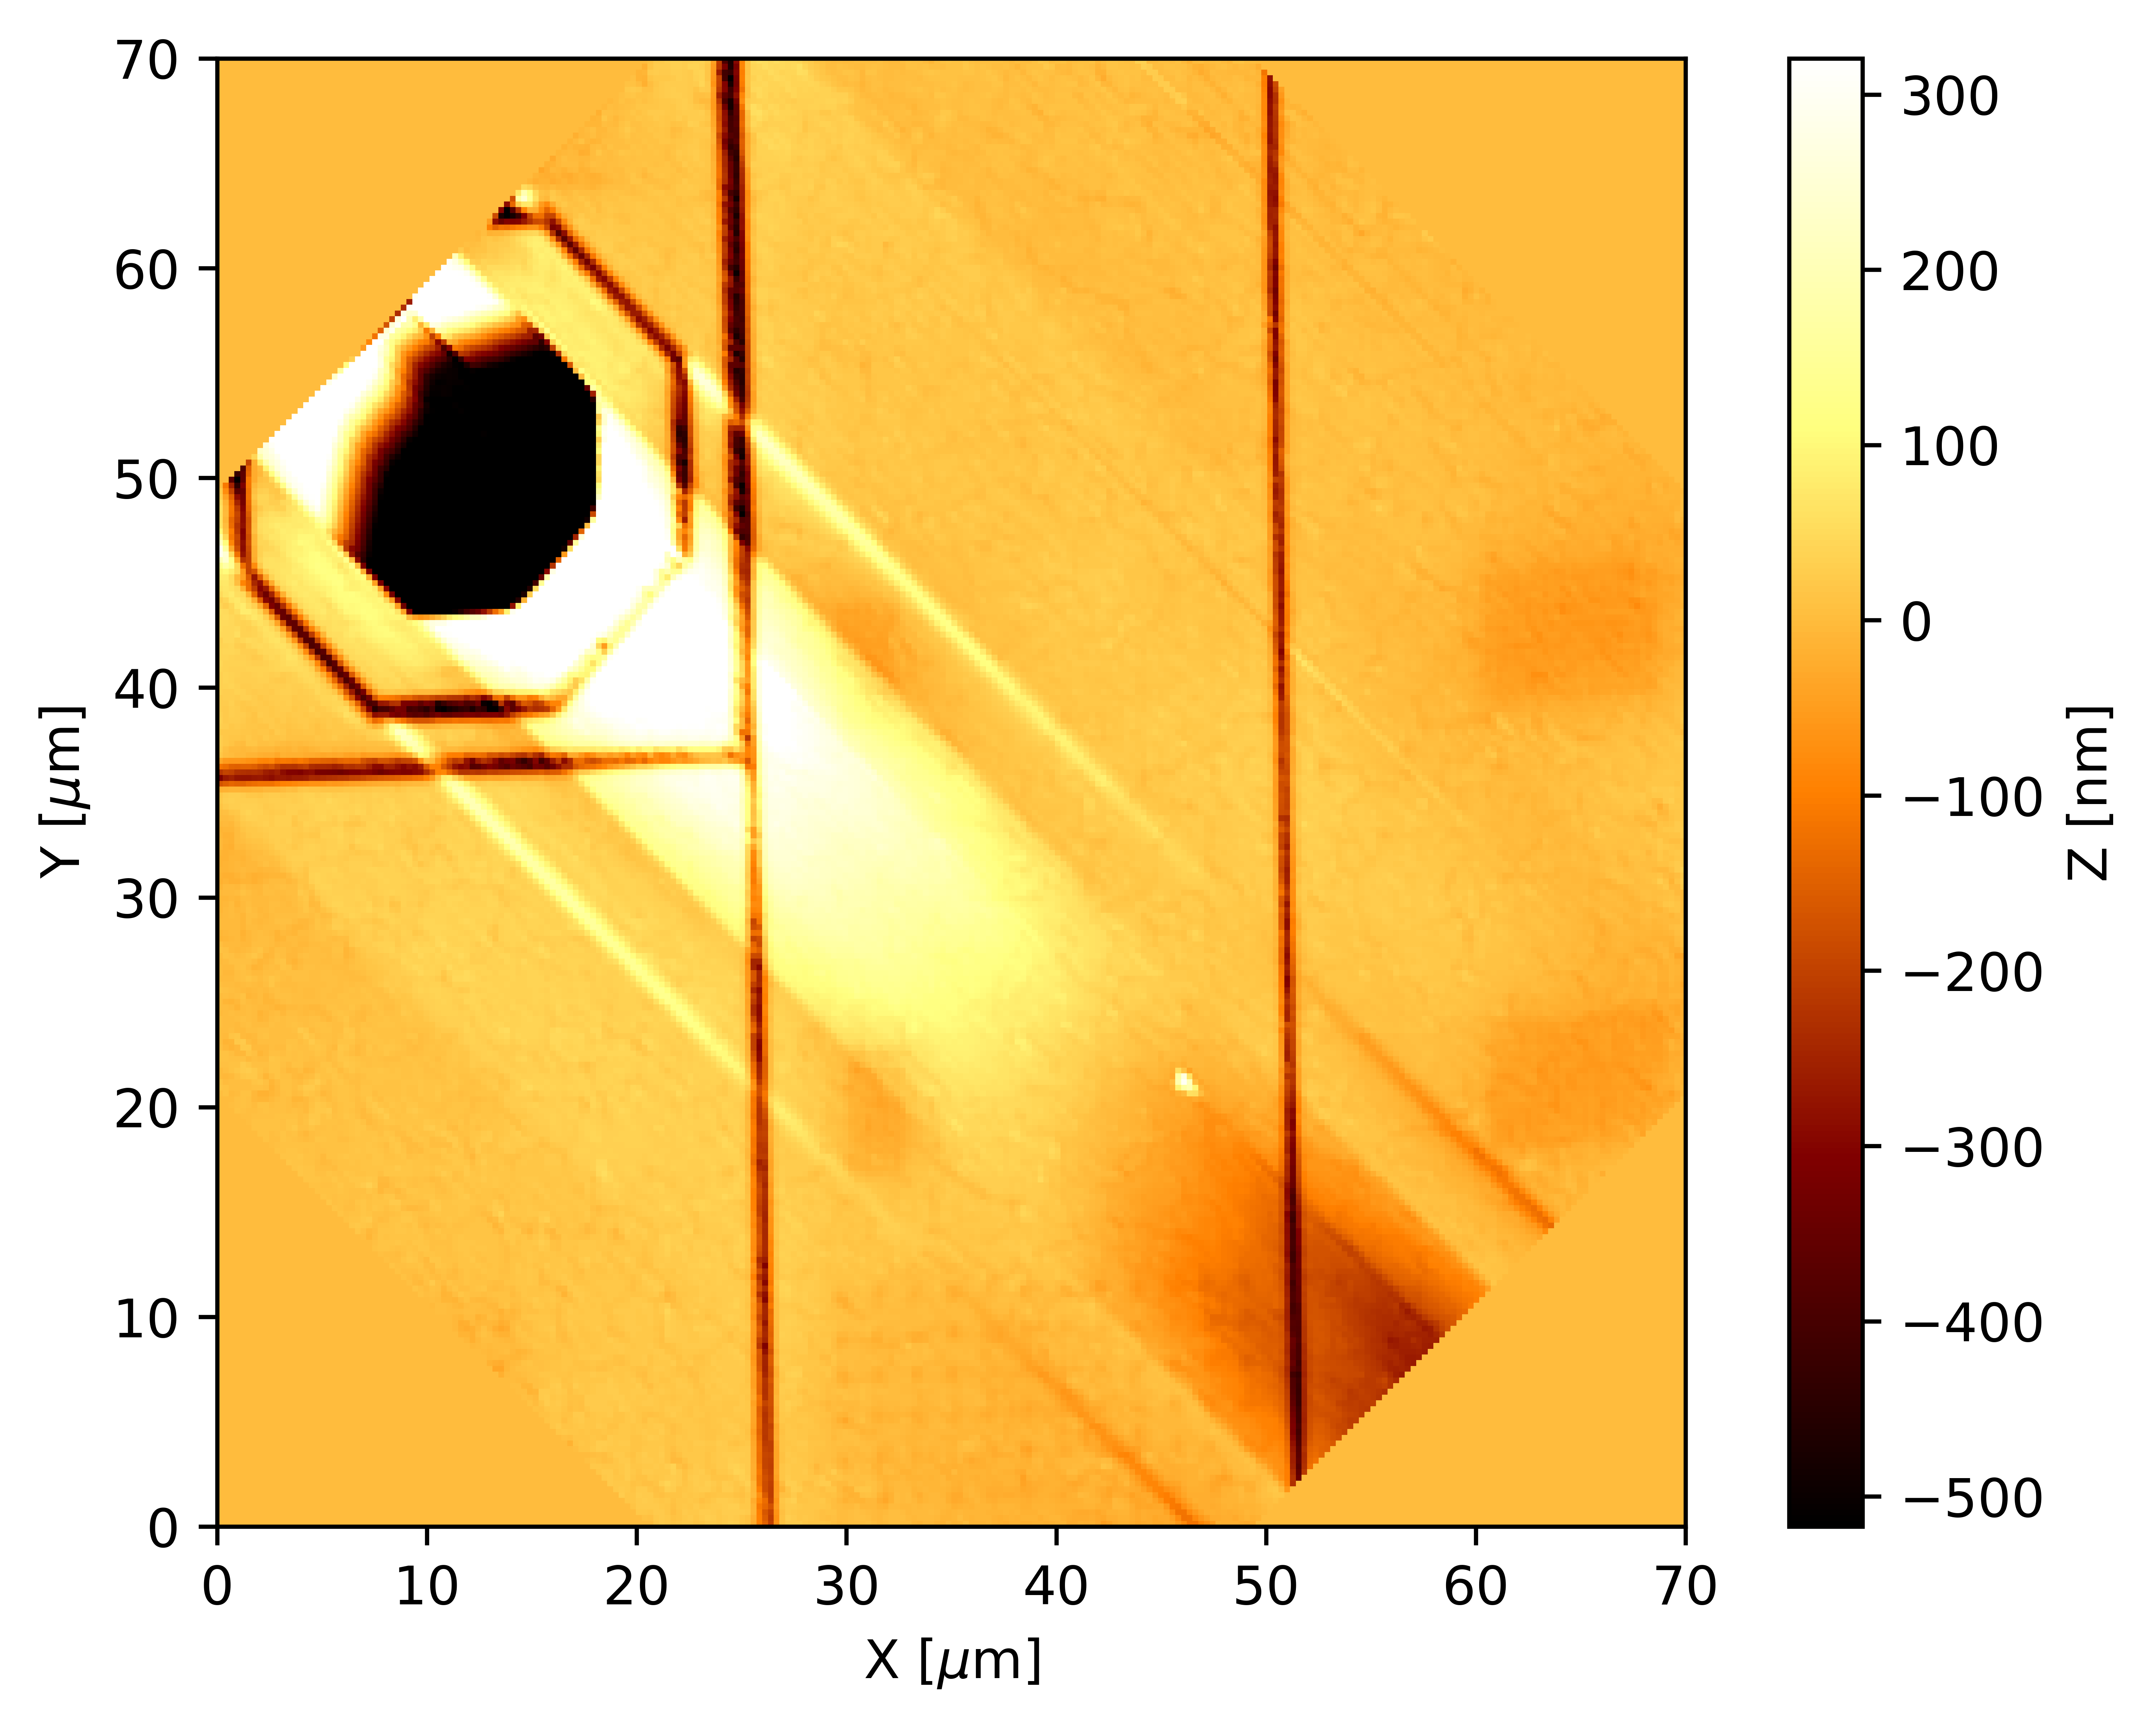

In [ ]:
# define function to plot data with colorbar
def plot2D(data, extents=extents, limits=clip):
    plt.figure(figsize=(7, 5), dpi=1024)
    im = plt.imshow(data,
                    extent = extents,
                    origin = 'lower',
                    clim = limits,
                    cmap='afmhot')

    plt.xlabel('X [$\mu$m]')
    plt.ylabel('Y [$\mu$m]')
    cb = plt.colorbar(im)
    cb.set_label('Z [nm]')
    plt.show()

plot2D(Zaxis_, extents=extents, limits=clip)

In [ ]:
# create mask to ignore data > 2 nm
mask = Zaxis_ > 2

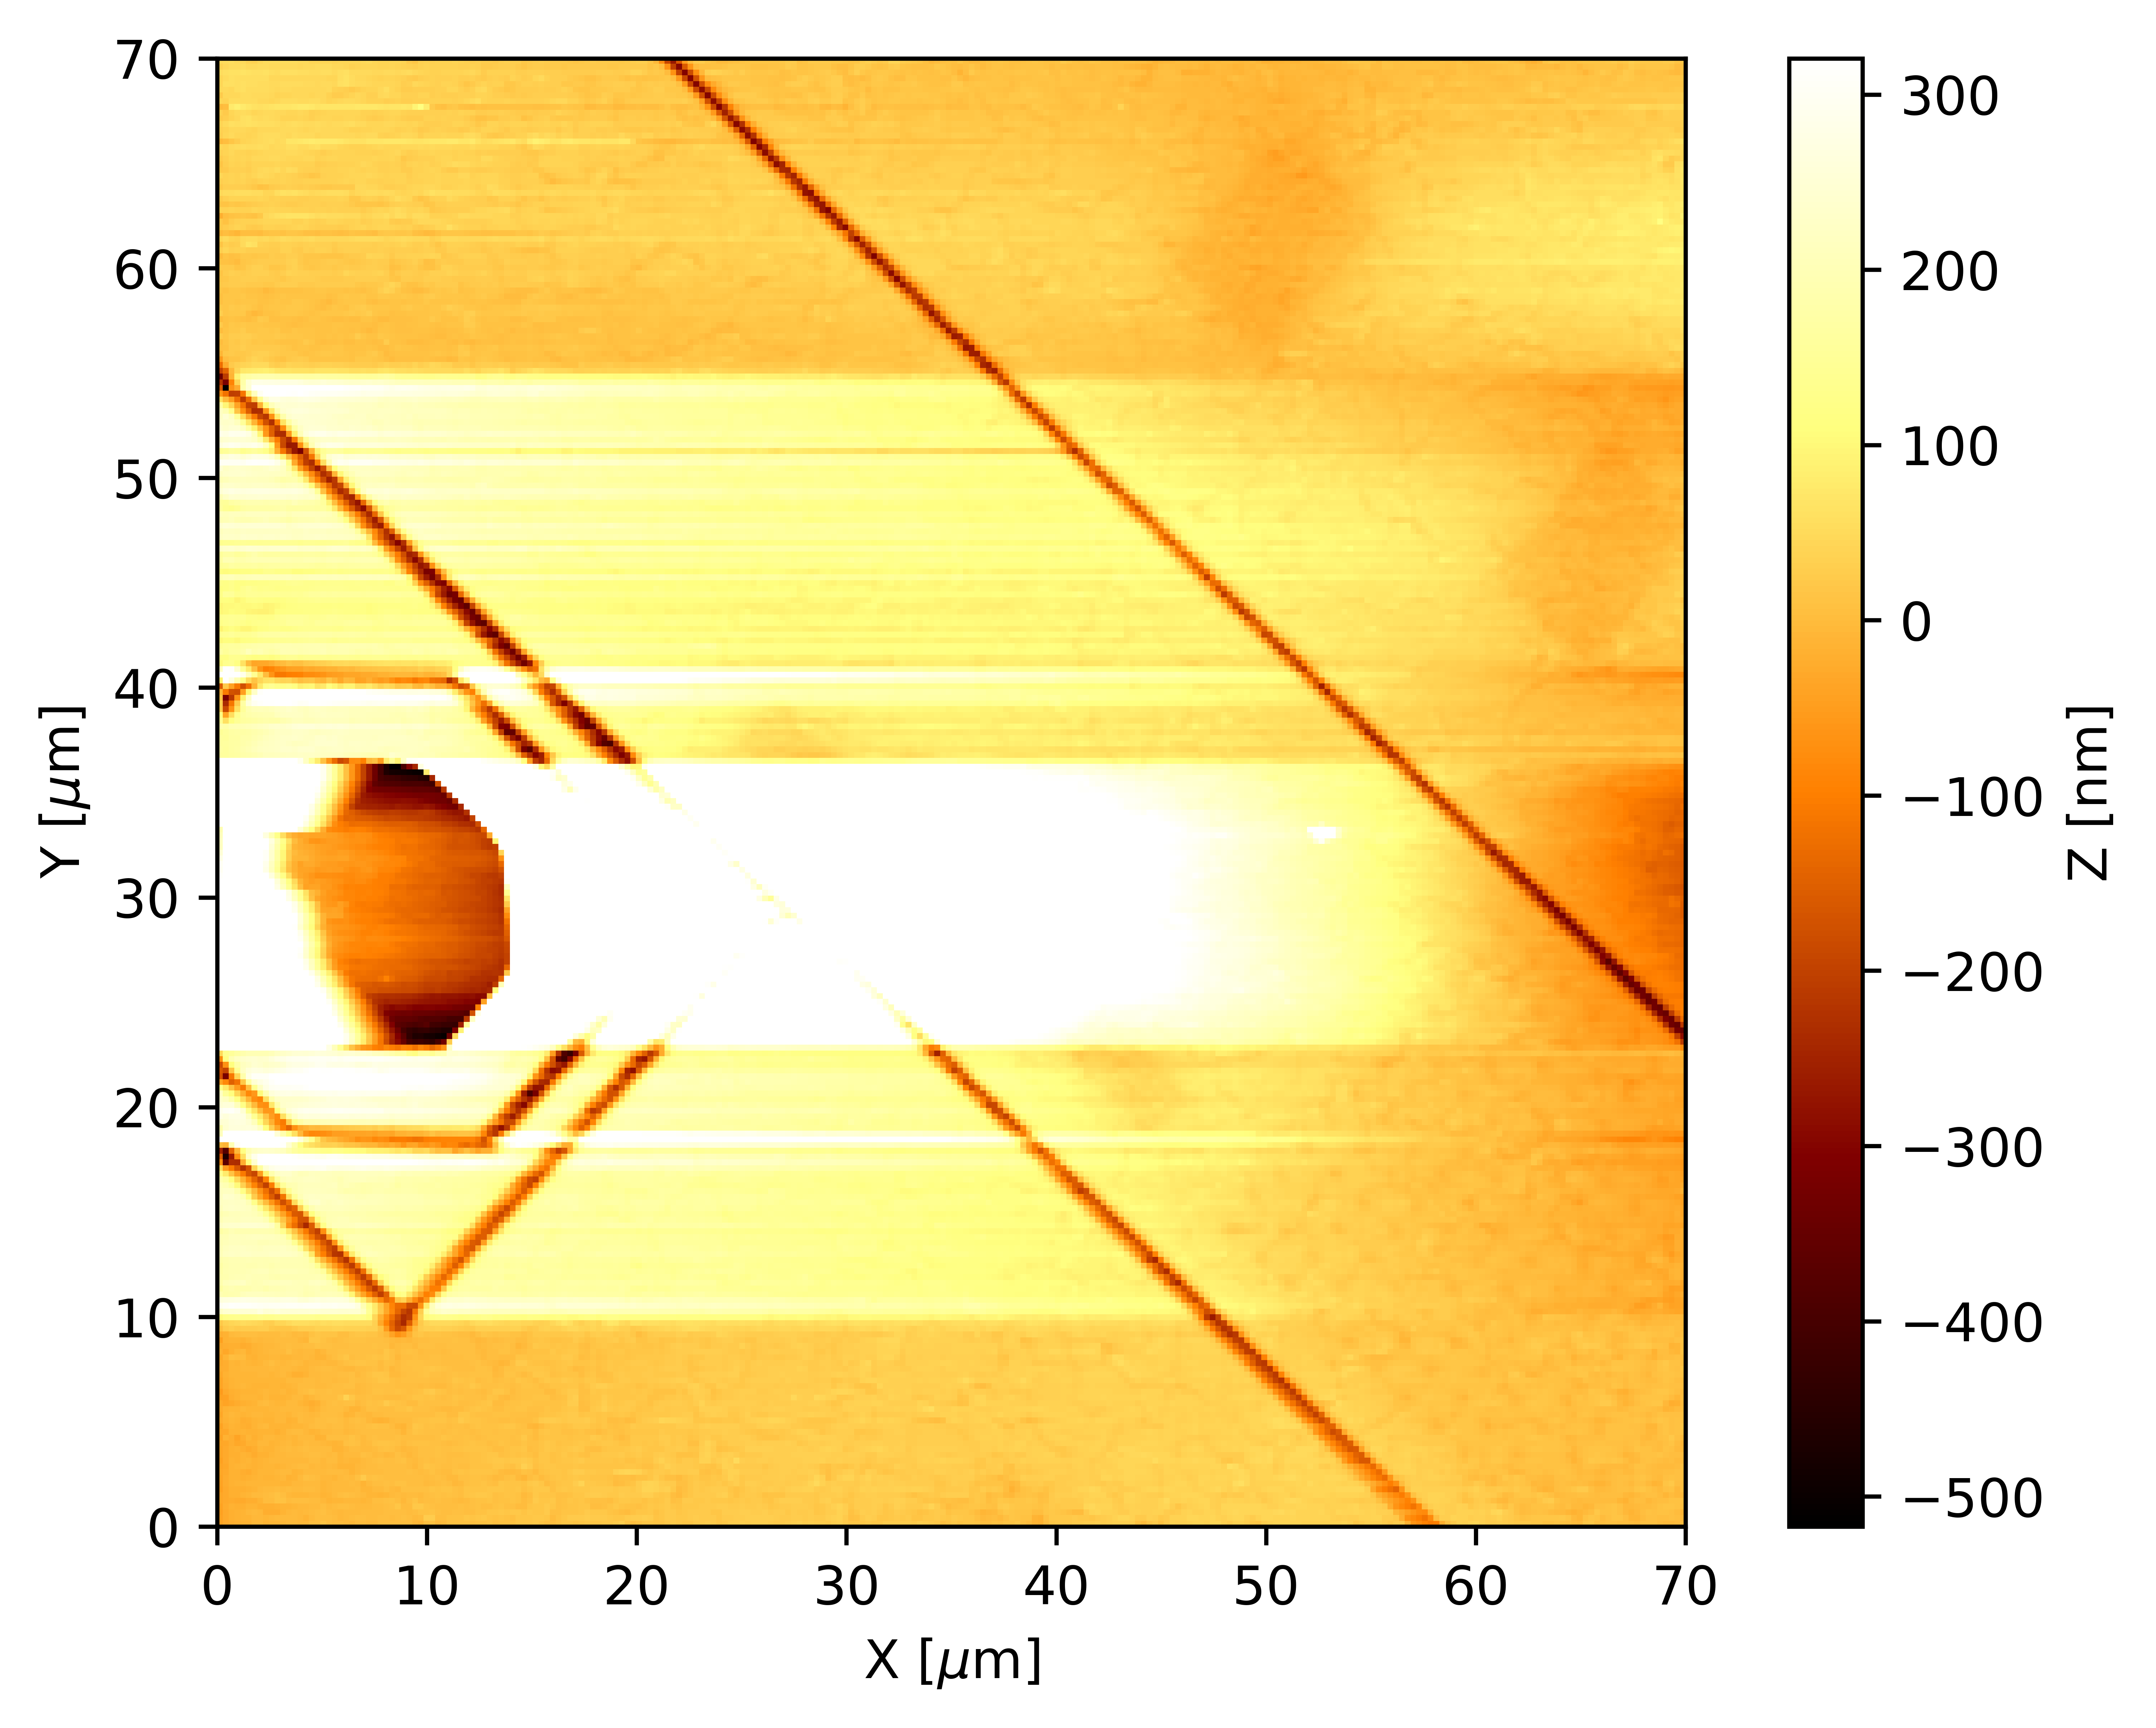

In [ ]:
# flatten data again but using mask
Zaxis_2 = flatten(Zaxis_, mask=mask)
plot2D(Zaxis_2)

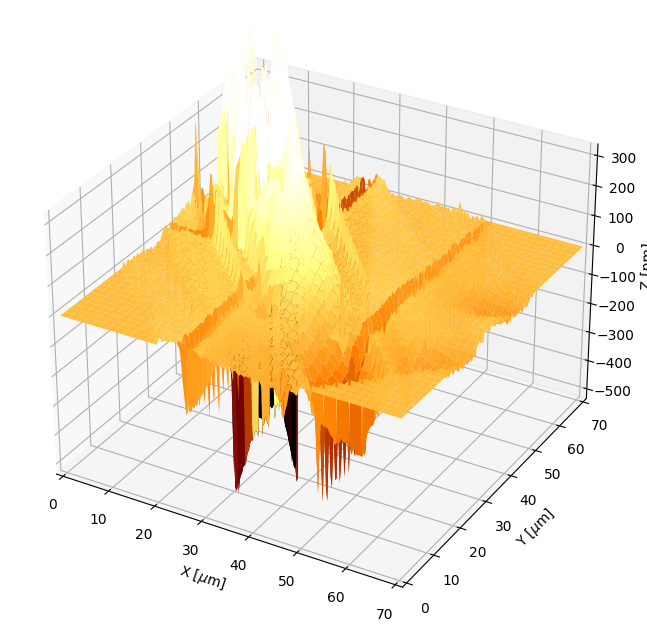

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3D(data, extents, limits):
    x = np.linspace(extents[0], extents[0] + extents[1], data.shape[1])
    y = np.linspace(extents[2], extents[2] + extents[3], data.shape[0])
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, data, cmap='afmhot', vmin=limits[0], vmax=limits[1])
    ax.set_xlabel('X [$\mu$m]')
    ax.set_ylabel('Y [$\mu$m]')
    ax.set_zlabel('Z [nm]')
    ax.set_xlim(extents[0], extents[0] + extents[1])
    ax.set_ylim(extents[2], extents[2] + extents[3])
    ax.set_zlim(limits[0], limits[1])
    plt.show()


plot3D(Zaxis_, extents=extents, limits=clip)




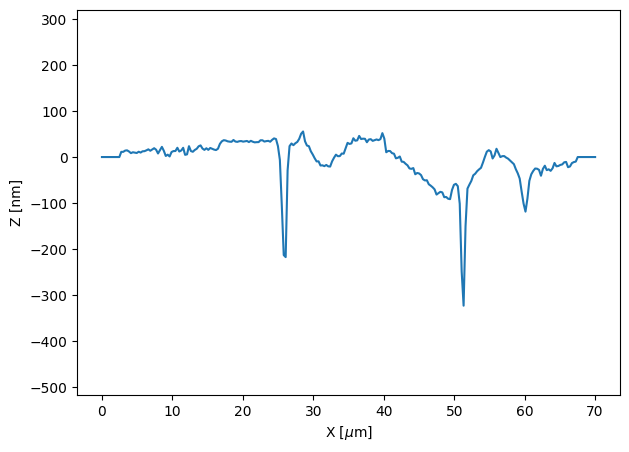

In [ ]:
def plotCrossSection(data, extents, limits, axis='X', position=0):
    if axis == 'X':
        cross_section = data[position, :]
        x = np.linspace(extents[0], extents[0] + extents[1], len(cross_section))

        xlabel = 'X [$\mu$m]'
    elif axis == 'Y':
        cross_section = data[:, position]
        x = np.linspace(extents[2], extents[2] + extents[3], len(cross_section))

        xlabel = 'Y [$\mu$m]'
    else:
        raise ValueError("Invalid axis. Use 'X' or 'Y'.")

    plt.figure(figsize=(7, 5))
    plt.plot(x, cross_section)
    plt.xlabel(xlabel)
    plt.ylabel('Z [nm]')
    plt.ylim(limits[0], limits[1])
    plt.show()

# Example usage to plot X-axis cross-section at position 50
plotCrossSection(Zaxis_, extents=extents, limits=clip, axis='X', position=65)
